This notebook contains all the code to access the optimal pair of b-values for the fwDTI model (article's Fig. 2).

A python file version of this notebook can be found in the code folder.

Importing relevant modules:

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import time
import sys
import os 
%matplotlib inline

# Change directory to the code folder
os.chdir('..//code')

# Functions to sample the diffusion-weighted gradient directions
from dipy.core.sphere import disperse_charges, HemiSphere

# Function to reconstruct the tables with the acquisition information
from dipy.core.gradients import gradient_table

# Functions to perform simulations based on multi-compartment models
from dipy.sims.voxel import multi_tensor

# Import Dipy's procedures to process diffusion tensor
import dipy.reconst.dti as dti

# Importing procedures to fit the free water elimination DTI model
from functions import nls_fit_tensor

Defining the acquisition parameters...

In [2]:
# Sample the spherical cordinates of 32 random diffusion-weighted
# directions.
n_pts = 32
theta = np.pi * np.random.rand(n_pts)
phi = 2 * np.pi * np.random.rand(n_pts)

# Convert direction to cartesian coordinates. For this, Dipy's
# class object HemiSphere is used. Since diffusion possess central
# symmetric, this class object also projects the direction to an
# Hemisphere.
hsph_initial = HemiSphere(theta=theta, phi=phi)

# By using a electrostatic potential energy algorithm, the directions
# of the HemiSphere class object are moved util them are evenly
# distributed in the Hemi-sphere
hsph_updated, potential = disperse_charges(hsph_initial, 5000)
directions = hsph_updated.vertices

# Define a matrix that contains the directions for all b-values
bvecs = np.vstack((np.zeros((6, 3)), directions, directions))

# Define the minimun and maximum b-values that will be tested
bmin = np.linspace(200, 800, num=7)
bmax = np.linspace(300, 1500, num=13)

# The SNR is defined according to Hoy et al, 2014
SNR = 40

# According to Hoy et al., the nominal SNR (SNR at b-value=0)
# is adjusted according to the maximum b-value from its
# associated TE values and assuming white matter T2 values of
# 70 ms.
T2 = 70.0

# Since TE values acquired for the original article were
# not provided, the TE values recorded from a 3T Siemmens
# Prisma scanner was used instead. These TE values are
# saved in the following vector:
TE = np.array([64.0, 65.0, 66.0, 68.0, 69.0, 70.0, 71.0,
               71.0, 72.0, 73.0, 74.0, 75.0, 75.0])

# Correction factor is set such that the acquisition
# with maximum b-value=1000 had a scaling factor of 1
sf = 1. / np.exp(-TE[7]/T2)

Defining the ground truth values for all simulations repetitions...

In [3]:
# Similarly to the original article, this analysis is performed
# for a volume fraction of 0.50
F = 0.50

# The value of free water diffusion is set to its known value
Dwater = 3e-3

# Similarly to the original article, this analysis is performed
# for a tissue diffusion tensor with high fractional anisotropy
FA = 0.712
L1 = 1.6e-3
L2 = 0.5e-3
L3 = 0.3e-3
TRACE = 2.4e-3

# According to Hoy et al., simulations are repeated for 120 different
# diffusion tensor directions (and each direction repeated 100 times).
nDTdirs = 120
nrep = 100

# These directions are sampled using the same procedure used
# to evenly sample the diffusion gradient directions
theta = np.pi * np.random.rand(nDTdirs)
phi = 2 * np.pi * np.random.rand(nDTdirs)
hsph_initial = HemiSphere(theta=theta, phi=phi)
hsph_updated, potential = disperse_charges(hsph_initial, 5000)
DTdirs = hsph_updated.vertices

# Prepare parameters for simulations
mevals = np.array([[L1, L2, L3], [Dwater, Dwater, Dwater]])
fractions = [100 - F*100, F*100]

Generating simulations and fwDTI fitting...

In [4]:
# Initializing a matrix to save all free-water DTI parameters.
# The first dimension of this matrix corresponds to the simulation
# repetitions for different minimum b-values tested, maximum
# b-value tested, diffusion tensor directions. The last dimension
# corresponds to the number of model parameters.
fw_params = np.zeros((bmin.size, bmax.size,
                      nDTdirs * nrep, 13))


# Lopping the simulations for the given maxima b-values
for bmax_i in range(bmax.size):

    # Adjust SNR according to a given maximum b-value
    SNRa = SNR * sf * np.exp(-TE[bmax_i]/T2)

    # Lopping the simulations for the given minima b-values
    for bmin_i in range(bmin.size):

        # Perform only simulations that make sense (i.e bmax > bmin )
        if bmax[bmax_i] > bmin[bmin_i]:

            # Generate Dipy's acquisition table for the given minimum and
            # maximum b-values
            bvals = np.hstack((np.zeros(6), bmin[bmin_i]*np.ones(n_pts),
                               bmax[bmax_i]*np.ones(n_pts)))
            gtab = gradient_table(bvals, bvecs)

            # Initialize a matrix that will save the data of all
            # repetitions for the given pair of minimum-maximun
            # b-value
            rep_simulates = np.zeros((nDTdirs * nrep, bvecs.shape[0]))

            # Repeat simulations for the 120 diffusion gradient directions
            for di in range(nDTdirs):
                d = DTdirs[di]

                # Repeat each direction 100 times
                for s_i in np.arange(di * nrep, (di+1) * nrep):

                    # Multi-compartmental simulations are done using
                    # Dipy's function multi_tensor
                    signal, sticks = multi_tensor(gtab, mevals, S0=100,
                                                  angles=[d, (1, 0, 0)],
                                                  fractions=fractions,
                                                  snr=SNRa)
                    rep_simulates[s_i, :] = signal

            # Process NLS fitting for all simulation repetitions of
            # a given pair of minimum-maximun b-value
            fw_params[bmin_i, bmax_i, :, :] = nls_fit_tensor(gtab,
                                                             rep_simulates)

            # Process computing progress
            prog = (bmax_i*1.0)/bmax.size + (bmin_i+1.0)/(bmax.size*bmin.size)
            prog = prog * 100
            time.sleep(1)
            sys.stdout.write("\r%f%%" % prog)
            sys.stdout.flush()

100.000000%

C:\Users\Rafael\Anaconda\lib\site-packages\scipy\optimize\minpack.py:427: RuntimeWarning: Number of calls to function has reached maxfev = 900.
  warnings.warn(errors[info][0], RuntimeWarning)


Compute FA and f-value statistics and save results

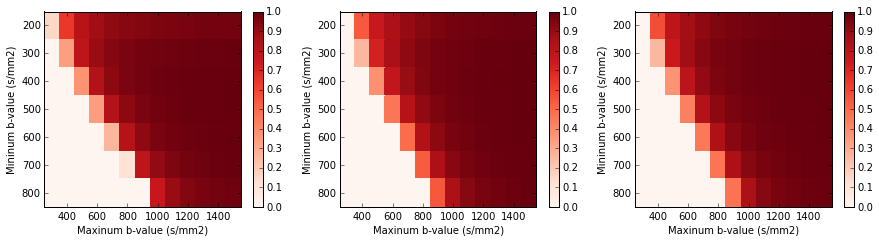

In [7]:
# select computed diffusion eigenvalues
evals = fw_params[..., :3]

# Compute the tissue's diffusion tensor fractional anisotropy
# using function fractional_anisotropy of Dipy's module dti
fa = dti.fractional_anisotropy(evals)

# select computed water volume fraction
f = fw_params[..., 12]

# Diffusion tensor trace is equal to the sum of eigenvalues
trace = np.sum(evals, axis=3)

# Compute the squared difference of each diffusion measurement
df2 = np.square(f - F)
dfa2 = np.square(fa - FA)
dtrace2 = np.square(trace - TRACE)

# Compute the mean squared error of each diffusion measuremen
msef = np.sum(df2, axis=2) / (nrep*nDTdirs)
msefa = np.sum(dfa2, axis=2) / (nrep*nDTdirs)
msetrace = np.sum(dtrace2, axis=2) / (nrep*nDTdirs)

# Compute the reciprocal scaled mean squared error
Bmax, Bmin = np.meshgrid(bmax, bmin)

msefmin = np.min(msef[Bmax > Bmin])  # MSE F minimun
msefamin = np.min(msefa[Bmax > Bmin])  # MSE FA minimun
msetracemax = np.max(msetrace[Bmax > Bmin])  # MSE Trace minimun
msefmax = np.max(msef[Bmax > Bmin])  # MSE F minimun
msefamax = np.max(msefa[Bmax > Bmin])  # MSE FA minimun
msetracemin = np.min(msetrace[Bmax > Bmin])  # MSE Trace minimun

rmsef = 1 - (msef-msefmin) / (msefmax-msefmin)
rmsefa = 1 - (msefa-msefamin) / (msefamax-msefamin)
rmsetrace = 1 - (msetrace-msetracemin) / (msetracemax-msetracemin)

# Figure setting
fig = plt.figure(figsize=(15, 3.5))
fig.subplots_adjust(wspace=0.2)

# Define the plot's grid edges
bmin_edge = np.linspace(150, 850, num=8)
bmax_edge = np.linspace(250, 1550, num=14)
Bmax_ed, Bmin_ed = np.meshgrid(bmax_edge, bmin_edge)

# Plotting he reciprocal scaled mean squared error for the
# volume fraction
plt.subplot(1, 3, 1)
plt.pcolormesh(Bmax_ed, Bmin_ed, rmsef,
               vmin=0, vmax=1, cmap='Reds')
plt.axis([250, 1550, 850, 150])
plt.colorbar()
plt.xlabel('Maxinum b-value (s/mm2)')
plt.ylabel('Mininum b-value (s/mm2)')

# Plotting he reciprocal scaled mean squared error for FA
plt.subplot(1, 3, 2)
plt.pcolormesh(Bmax_ed, Bmin_ed, rmsefa,
               vmin=0, vmax=1, cmap='Reds')
plt.axis([250, 1550, 850, 150])
plt.colorbar()
plt.xlabel('Maxinum b-value (s/mm2)')
plt.ylabel('Mininum b-value (s/mm2)')

# Plotting he reciprocal scaled mean squared error for diffusion
# trace
plt.subplot(1, 3, 3)
plt.pcolormesh(Bmax_ed, Bmin_ed, rmsetrace,
               vmin=0, vmax=1, cmap='Reds')
plt.axis([250, 1550, 850, 150])
plt.colorbar()
plt.xlabel('Maxinum b-value (s/mm2)')
plt.ylabel('Mininum b-value (s/mm2)')

plt.show()

fig.savefig('fwdti_simulations_2.png', bbox_inches='tight')

Panels above show that our fwDTI fitting procedures are less dependent on the b-values than the original articles. For a better visualization of the optimal pair of b-values, the figures is ploted again with adjusted color-scale range. 

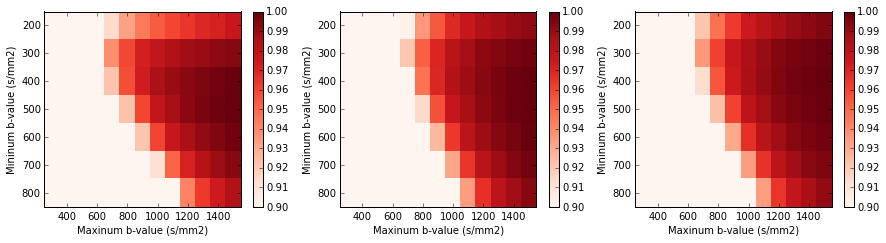

In [8]:
# Figure setting
fig = plt.figure(figsize=(15, 3.5))
fig.subplots_adjust(wspace=0.2)

# Define the plot's grid edges
bmin_edge = np.linspace(150, 850, num=8)
bmax_edge = np.linspace(250, 1550, num=14)
Bmax_ed, Bmin_ed = np.meshgrid(bmax_edge, bmin_edge)

# Plotting he reciprocal scaled mean squared error for the
# volume fraction
plt.subplot(1, 3, 1)
plt.pcolormesh(Bmax_ed, Bmin_ed, rmsef,
               vmin=0.9, vmax=1, cmap='Reds')
plt.axis([250, 1550, 850, 150])
plt.colorbar()
plt.xlabel('Maxinum b-value (s/mm2)')
plt.ylabel('Mininum b-value (s/mm2)')

# Plotting he reciprocal scaled mean squared error for FA
plt.subplot(1, 3, 2)
plt.pcolormesh(Bmax_ed, Bmin_ed, rmsefa,
               vmin=0.9, vmax=1, cmap='Reds')
plt.axis([250, 1550, 850, 150])
plt.colorbar()
plt.xlabel('Maxinum b-value (s/mm2)')
plt.ylabel('Mininum b-value (s/mm2)')

# Plotting he reciprocal scaled mean squared error for diffusion
# trace
plt.subplot(1, 3, 3)
plt.pcolormesh(Bmax_ed, Bmin_ed, rmsetrace,
               vmin=0.9, vmax=1, cmap='Reds')
plt.axis([250, 1550, 850, 150])
plt.colorbar()
plt.xlabel('Maxinum b-value (s/mm2)')
plt.ylabel('Mininum b-value (s/mm2)')

plt.show()

fig.savefig('fwdti_simulations_2_rescaled.png', bbox_inches='tight')

In analogous to Hoy et al. (2014), the b-value pair $500-1500 s.mm^{-2}$ seems to be optimal for fwDTI fitting.